In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
loan = pd.read_csv("Train_Data.csv")
loan.set_index("ID", inplace = True)

In [3]:
loan.reset_index(drop=True, inplace = True)

In [4]:
loan.head()

,Income_of_Applicant,Income_of_Joint_Applicant,Loan_Amount_Requirement,Loan_Amount_Term,Credit_History,Gender,Is_Married,No_of_Dependents,Level_of_Education,IS_Self_Employed,Area_of_Property,Loan_Status
0,5849,0.0,NaN,360.0,1.0,Male,No,0,Graduate,No,Urban,Y
1,4583,1508.0,128.0,360.0,1.0,Male,Yes,1,Graduate,No,Rural,N
2,3000,0.0,66.0,360.0,1.0,Male,Yes,0,Graduate,Yes,Urban,Y
3,2583,2358.0,120.0,360.0,1.0,Male,Yes,0,Not Graduate,No,Urban,Y
4,6000,0.0,141.0,360.0,1.0,Male,No,0,Graduate,No,Urban,Y


In [5]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Income_of_Applicant        614 non-null    int64  
 1   Income_of_Joint_Applicant  614 non-null    float64
 2   Loan_Amount_Requirement    592 non-null    float64
 3   Loan_Amount_Term           600 non-null    float64
 4   Credit_History             564 non-null    float64
 5   Gender                     601 non-null    object 
 6   Is_Married                 611 non-null    object 
 7   No_of_Dependents           599 non-null    object 
 8   Level_of_Education         614 non-null    object 
 9   IS_Self_Employed           582 non-null    object 
 10  Area_of_Property           614 non-null    object 
 11  Loan_Status                614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


In [6]:
loan.duplicated().sum()

0

In [7]:
loan.isnull().sum()

Income_of_Applicant           0
Income_of_Joint_Applicant     0
Loan_Amount_Requirement      22
Loan_Amount_Term             14
Credit_History               50
Gender                       13
Is_Married                    3
No_of_Dependents             15
Level_of_Education            0
IS_Self_Employed             32
Area_of_Property              0
Loan_Status                   0
dtype: int64

In [8]:
print("Total rows with missing values: " + str(round((loan.isnull().any(axis=1).sum()/loan.shape[0])*100,2)) + " % of total data!!!")

Total rows with missing values: 21.82 % of total data!!!


In [9]:
loan.columns[loan.isnull().sum()>0]

Index(['Loan_Amount_Requirement', 'Loan_Amount_Term', 'Credit_History',
       'Gender', 'Is_Married', 'No_of_Dependents', 'IS_Self_Employed'],
      dtype='object')

#### Columns in dataset with missing values are:
'Loan_Amount_Requirement', 'Loan_Amount_Term', 'Credit_History',
       'Gender', 'Is_Married', 'No_of_Dependents', 'IS_Self_Employed'

Text(0.5, 1.0, 'IS_Self_Employed')

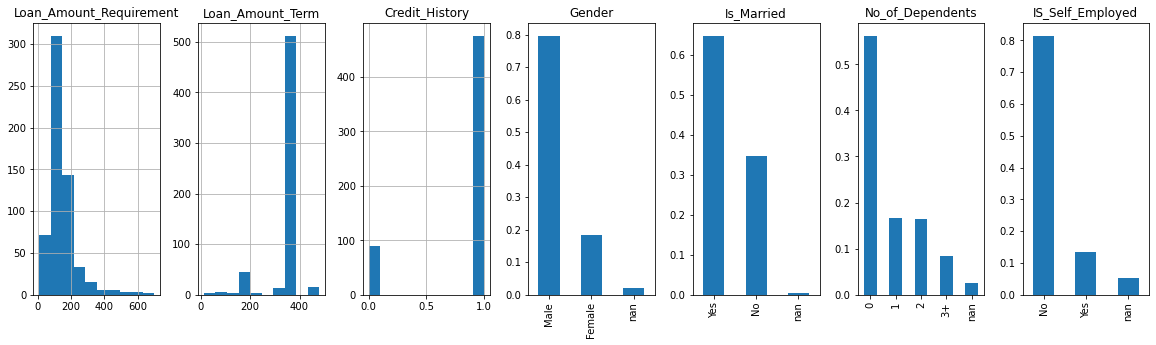

In [10]:
fig, axes = plt.subplots(1, 7, figsize = (20,5))

loan.hist("Loan_Amount_Requirement", ax = axes [0])
loan.hist("Loan_Amount_Term", ax = axes[1])
loan.hist("Credit_History", ax = axes[2])
loan.Gender.value_counts(normalize = True, dropna = False).plot(kind="bar", ax = axes[3]).set_title("Gender")
loan.Is_Married.value_counts(normalize = True, dropna = False).plot(kind="bar", ax = axes[4]).set_title("Is_Married")
loan.No_of_Dependents.value_counts(normalize = True, dropna = False).plot(kind="bar", ax = axes[5]).set_title("No_of_Dependents")
loan.IS_Self_Employed.value_counts(normalize = True, dropna = False).plot(kind="bar", ax = axes[6]).set_title("IS_Self_Employed")

## For now, removing all missing values to simplify further process! 

In [11]:
# loan.dropna(inplace = True)
# loan.isnull().sum()

In [12]:
loan.shape

(614, 12)

array([[<AxesSubplot:title={'center':'Income_of_Applicant'}>,
        <AxesSubplot:title={'center':'Income_of_Joint_Applicant'}>],
       [<AxesSubplot:title={'center':'Loan_Amount_Requirement'}>,
        <AxesSubplot:title={'center':'Loan_Amount_Term'}>],
       [<AxesSubplot:title={'center':'Credit_History'}>, <AxesSubplot:>]],
      dtype=object)

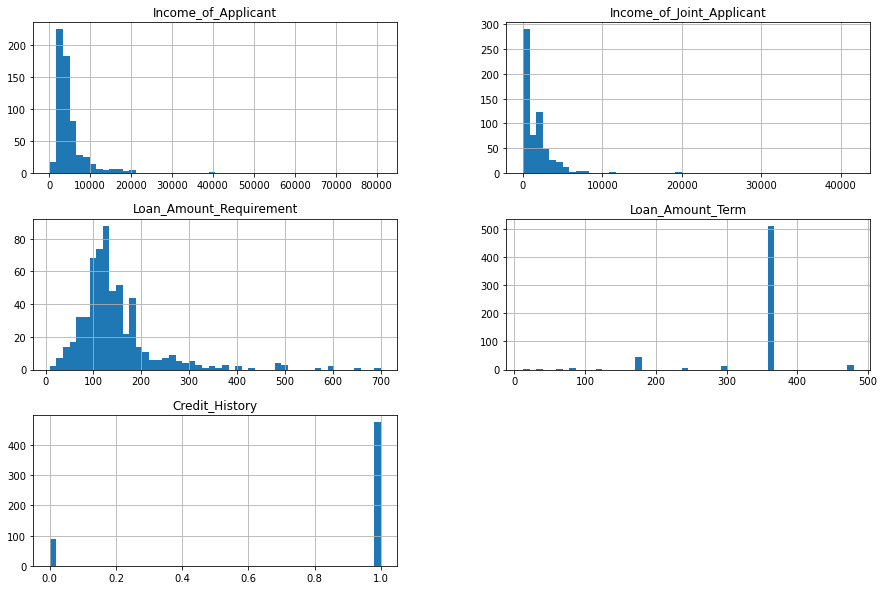

In [13]:
loan.hist(bins = 50, figsize = (15,10))

<AxesSubplot:>

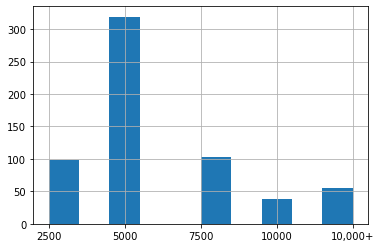

In [14]:
# creating "income cat" to check distribution
loan["income_cat"] = pd.cut(loan["Income_of_Applicant"], bins = [0., 2500., 5000., 7500., 10000., np.inf], labels = [2500, 5000, 7500, 10000, "10,000+"], right = False)
# (loan["income_cat"].value_counts()/len(loan["income_cat"]))*100
loan["income_cat"].sort_values().hist()

Checking Loan_Status based on Area_of_Property & Loan_Amount_Requirement

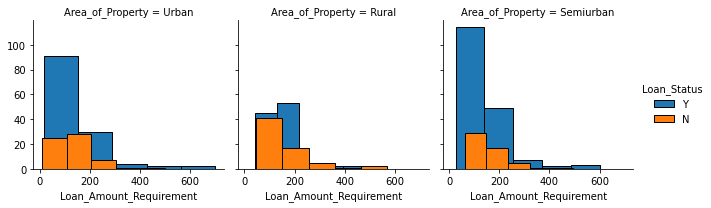

In [15]:
sns.FacetGrid(loan, hue = "Loan_Status", col = "Area_of_Property", height = 3).map(plt.hist, "Loan_Amount_Requirement", bins = 5, ec = "k").add_legend()

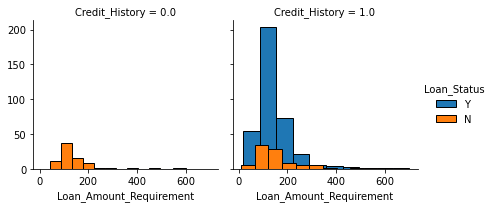

In [16]:
sns.FacetGrid(loan, hue = "Loan_Status", col = "Credit_History", height = 3).map(plt.hist, "Loan_Amount_Requirement", ec = "k").add_legend()

#### Credit_History = 1.0 has strong affect on Loan Status!

In [17]:
(loan["Credit_History"].value_counts(dropna=False)/len(loan["Credit_History"]))*100

1.0    77.361564
0.0    14.495114
NaN     8.143322
Name: Credit_History, dtype: float64

### Checking target variable classes

In [18]:
(loan["Loan_Status"].value_counts(dropna=False)/len(loan["Loan_Status"]))*100

Y    68.729642
N    31.270358
Name: Loan_Status, dtype: float64

## Create a test set to prevent data snooping bias!

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

In [20]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

In [21]:
# Delete this
for train_index_s, test_index_s in split.split(loan, loan["Loan_Status"]):
    strat_train_set = loan.iloc[train_index_s]
    strat_test_set = loan.iloc[test_index_s]

strat_train_set.head()

,Income_of_Applicant,Income_of_Joint_Applicant,Loan_Amount_Requirement,Loan_Amount_Term,Credit_History,Gender,Is_Married,No_of_Dependents,Level_of_Education,IS_Self_Employed,Area_of_Property,Loan_Status,income_cat
154,3254,0.0,50.0,360.0,1.0,Male,No,0,Graduate,No,Urban,Y,5000
239,3315,0.0,96.0,360.0,1.0,Male,Yes,1,Graduate,No,Semiurban,Y,5000
448,3340,1710.0,150.0,360.0,0.0,Male,Yes,2,Graduate,No,Rural,N,5000
471,2653,1500.0,113.0,180.0,0.0,Male,Yes,1,Not Graduate,No,Rural,N,5000
273,2620,2223.0,150.0,360.0,1.0,Male,Yes,0,Graduate,No,Semiurban,Y,5000


In [22]:
# for train_index_s, test_index_s in split.split(loan, loan["Credit_History"]):
#     strat_train_set = loan.iloc[train_index_s]
#     strat_test_set = loan.iloc[test_index_s]

# strat_train_set.head()

In [23]:
# This is simple random sampling.
# np.random.seed(42)
# shuffles = np.random.permutation(len(loan))

# test_ratio = 0.8
# train_set_size = int(len(loan) * test_ratio)

# train_index = shuffles[:train_set_size]
# test_index = shuffles[train_set_size:]

# train_set = loan.iloc[train_index]
# test_set = loan.iloc[test_index]

In [24]:
(strat_train_set["Loan_Status"].value_counts()/len(strat_train_set["Loan_Status"]))*100

Y    68.635438
N    31.364562
Name: Loan_Status, dtype: float64

In [25]:
(strat_train_set["Credit_History"].value_counts()/len(strat_train_set["Credit_History"]))*100

1.0    77.596741
0.0    13.645621
Name: Credit_History, dtype: float64

Train set now contains similar distribution in terms of the "Credit_History" column!

<AxesSubplot:>

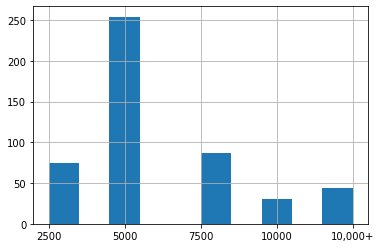

In [26]:
strat_train_set["income_cat"].sort_values().hist()
# All categories are present

In [27]:
# Deleting the "income cat" column from both train & test sets
strat_train_set = strat_train_set.drop(["income_cat"], axis = 1)
strat_test_set = strat_test_set.drop(["income_cat"], axis = 1)

In [28]:
strat_train_set.corr()["Income_of_Applicant"].sort_values(ascending = False)

Income_of_Applicant          1.000000
Loan_Amount_Requirement      0.602661
Credit_History              -0.045082
Loan_Amount_Term            -0.045426
Income_of_Joint_Applicant   -0.130215
Name: Income_of_Applicant, dtype: float64

array([[<AxesSubplot:xlabel='Income_of_Applicant', ylabel='Income_of_Applicant'>,
        <AxesSubplot:xlabel='Income_of_Joint_Applicant', ylabel='Income_of_Applicant'>,
        <AxesSubplot:xlabel='Loan_Amount_Requirement', ylabel='Income_of_Applicant'>,
        <AxesSubplot:xlabel='Loan_Amount_Term', ylabel='Income_of_Applicant'>,
        <AxesSubplot:xlabel='Credit_History', ylabel='Income_of_Applicant'>],
       [<AxesSubplot:xlabel='Income_of_Applicant', ylabel='Income_of_Joint_Applicant'>,
        <AxesSubplot:xlabel='Income_of_Joint_Applicant', ylabel='Income_of_Joint_Applicant'>,
        <AxesSubplot:xlabel='Loan_Amount_Requirement', ylabel='Income_of_Joint_Applicant'>,
        <AxesSubplot:xlabel='Loan_Amount_Term', ylabel='Income_of_Joint_Applicant'>,
        <AxesSubplot:xlabel='Credit_History', ylabel='Income_of_Joint_Applicant'>],
       [<AxesSubplot:xlabel='Income_of_Applicant', ylabel='Loan_Amount_Requirement'>,
        <AxesSubplot:xlabel='Income_of_Joint_Applicant', y

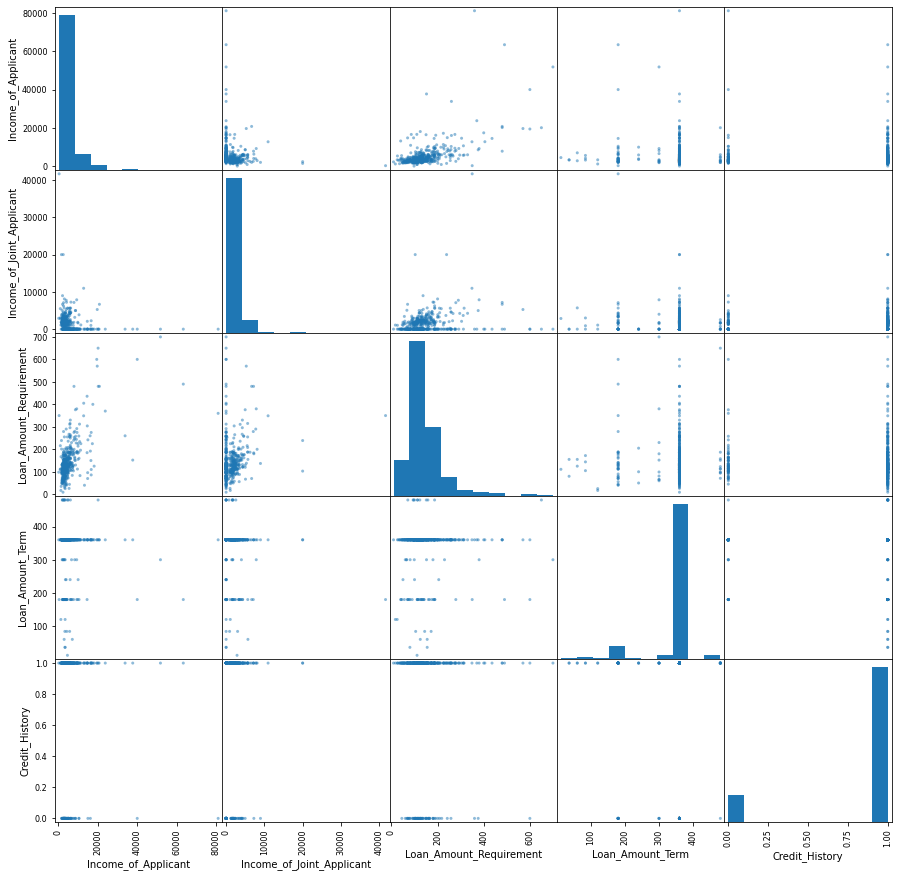

In [29]:
pd.plotting.scatter_matrix(strat_train_set, figsize = (15,15))

<AxesSubplot:xlabel='Income_of_Applicant', ylabel='Loan_Amount_Requirement'>

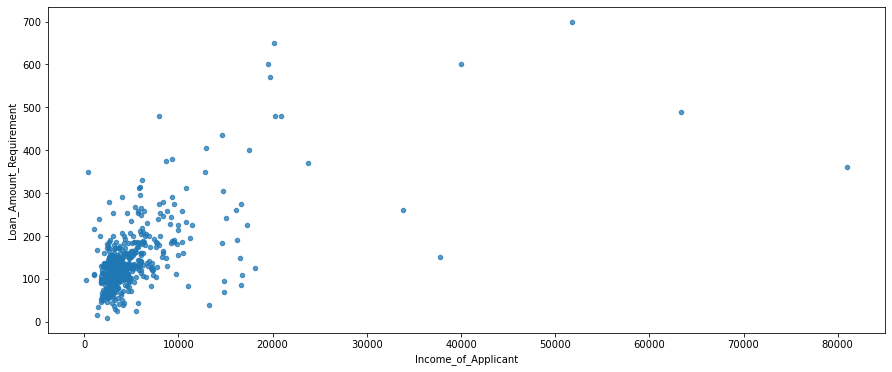

In [30]:
strat_train_set.plot(kind = "scatter", x = "Income_of_Applicant", y = "Loan_Amount_Requirement", alpha = 0.75, figsize = (15,6))

we see correlation between the two independent variables - "Income_of_Applicant" & "Loan_Amount_Requirement" which we can explore later!

### Now  we can start building our model!

### Starting with creating new training set!

In [31]:
strat_train_set.dropna(inplace=True)
strat_test_set.dropna(inplace=True)

In [32]:
train_loan_x = strat_train_set.drop("Loan_Status", axis = 1)
train_loan_y = strat_train_set["Loan_Status"]

In [33]:
test_loan_x = strat_test_set.drop("Loan_Status", axis = 1)
test_loan_y = strat_test_set["Loan_Status"]

In [34]:
train_loan_x.head()

,Income_of_Applicant,Income_of_Joint_Applicant,Loan_Amount_Requirement,Loan_Amount_Term,Credit_History,Gender,Is_Married,No_of_Dependents,Level_of_Education,IS_Self_Employed,Area_of_Property
154,3254,0.0,50.0,360.0,1.0,Male,No,0,Graduate,No,Urban
239,3315,0.0,96.0,360.0,1.0,Male,Yes,1,Graduate,No,Semiurban
448,3340,1710.0,150.0,360.0,0.0,Male,Yes,2,Graduate,No,Rural
471,2653,1500.0,113.0,180.0,0.0,Male,Yes,1,Not Graduate,No,Rural
273,2620,2223.0,150.0,360.0,1.0,Male,Yes,0,Graduate,No,Semiurban


In [35]:
train_loan_y.head()

154    Y
239    Y
448    N
471    N
273    Y
Name: Loan_Status, dtype: object

In [36]:
train_loan_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381 entries, 154 to 354
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Income_of_Applicant        381 non-null    int64  
 1   Income_of_Joint_Applicant  381 non-null    float64
 2   Loan_Amount_Requirement    381 non-null    float64
 3   Loan_Amount_Term           381 non-null    float64
 4   Credit_History             381 non-null    float64
 5   Gender                     381 non-null    object 
 6   Is_Married                 381 non-null    object 
 7   No_of_Dependents           381 non-null    object 
 8   Level_of_Education         381 non-null    object 
 9   IS_Self_Employed           381 non-null    object 
 10  Area_of_Property           381 non-null    object 
dtypes: float64(4), int64(1), object(6)
memory usage: 35.7+ KB


In [37]:
for i in train_loan_x.columns:
    if train_loan_x[i].dtypes == "O":
        print(i + " -> " + str(train_loan_x[i].unique()))

Gender -> ['Male' 'Female']
Is_Married -> ['No' 'Yes']
No_of_Dependents -> ['0' '1' '2' '3+']
Level_of_Education -> ['Graduate' 'Not Graduate']
IS_Self_Employed -> ['No' 'Yes']
Area_of_Property -> ['Urban' 'Semiurban' 'Rural']


As the number of categories is low, we can use Label encoding instead of One-Hot encoding.

In [38]:
def binarize_1hot(dataset, to_binarize, to_one_hot):
    for i in to_binarize:
        dataset[i] = LabelBinarizer().fit_transform(dataset[i])
    dataset = pd.get_dummies(data = dataset, columns = to_one_hot)
    return dataset

In [39]:
# label encoding & one-hot encoding train_X data

to_binarize = ["Gender", "Is_Married", "Level_of_Education", "IS_Self_Employed"]
to_one_hot = ["No_of_Dependents", "Area_of_Property"]

train_x_encoded = binarize_1hot(train_loan_x, to_binarize, to_one_hot)
test_x_encoded = binarize_1hot(test_loan_x, to_binarize, to_one_hot)

In [40]:
# from sklearn.preprocessing import LabelBinarizer
# to_binarize = ["Gender", "Is_Married", "Level_of_Education", "IS_Self_Employed"]
# to_one_hot = ["No_of_Dependents", "Area_of_Property"]
# for i in to_binarize:
#     train_loan_x[i] = LabelBinarizer().fit_transform(train_loan_x[i])
# train_loan_x = pd.get_dummies(data = train_loan_x, columns = to_one_hot)

In [41]:
# Use this below instead of get_dummies also
# from sklearn.preprocessing import OneHotEncoder
# one_enc = OneHotEncoder()
# train_loan_x_one_hot = one_enc.fit_transform(train_loan_x[["No_of_Dependents"]])
# train_loan_x_one_hot = pd.DataFrame(train_loan_x_one_hot.toarray())
# print(train_loan_x_one_hot.head())
# print(one_enc.categories_)

In [42]:
for i in train_x_encoded.columns:
    if train_x_encoded[i].dtypes == "int" or train_x_encoded[i].dtypes == "uint8":
        print(i + " -> " + str(train_x_encoded[i].unique()))

Gender -> [1 0]
Is_Married -> [0 1]
Level_of_Education -> [0 1]
IS_Self_Employed -> [0 1]
No_of_Dependents_0 -> [1 0]
No_of_Dependents_1 -> [0 1]
No_of_Dependents_2 -> [0 1]
No_of_Dependents_3+ -> [0 1]
Area_of_Property_Rural -> [0 1]
Area_of_Property_Semiurban -> [0 1]
Area_of_Property_Urban -> [1 0]


In [43]:
train_x_encoded.head()

,Income_of_Applicant,Income_of_Joint_Applicant,Loan_Amount_Requirement,Loan_Amount_Term,Credit_History,Gender,Is_Married,Level_of_Education,IS_Self_Employed,No_of_Dependents_0,No_of_Dependents_1,No_of_Dependents_2,No_of_Dependents_3+,Area_of_Property_Rural,Area_of_Property_Semiurban,Area_of_Property_Urban
154,3254,0.0,50.0,360.0,1.0,1,0,0,0,1,0,0,0,0,0,1
239,3315,0.0,96.0,360.0,1.0,1,1,0,0,0,1,0,0,0,1,0
448,3340,1710.0,150.0,360.0,0.0,1,1,0,0,0,0,1,0,1,0,0
471,2653,1500.0,113.0,180.0,0.0,1,1,1,0,0,1,0,0,1,0,0
273,2620,2223.0,150.0,360.0,1.0,1,1,0,0,1,0,0,0,0,1,0


In [44]:
# Min-Max Scaler function
def mm_scaler(dataset):
    mmscaler = MinMaxScaler()
    data_scaled = mmscaler.fit_transform(dataset)
    return data_scaled

train_x_encoded_scaled = mm_scaler(train_x_encoded)
test_x_encoded_scaled = mm_scaler(test_x_encoded)

In [45]:
# label encoding

def label_encode(dataset):
    label_enc = LabelBinarizer()
    dataset_encoded = label_enc.fit_transform(dataset)
    return dataset_encoded

train_y_encoded_scaled = label_encode(train_loan_y)
test_y_encoded_scaled = label_encode(test_loan_y)

In [46]:
# # Min-Max Scaling train_X data

# mm_scaler = MinMaxScaler()
# train_x_encoded_scaled = mm_scaler.fit_transform(train_x_encoded)
# train_x_encoded_scaled

In [47]:
# # label encoding train_y data
# label_bin_y = LabelBinarizer()
# train_loan_y_encoded = label_bin_y.fit_transform(train_loan_y)
# train_loan_y_encoded.shape

In [48]:
# # Min-Max Scaling train_y data
# mm_scaler = MinMaxScaler()
# train_y_encoded_scaled = mm_scaler.fit_transform(train_loan_y_encoded)
# train_y_encoded_scaled.shape

In [49]:
# # label encoding & one-hot encoding test_x data

# to_binarize = ["Gender", "Is_Married", "Level_of_Education", "IS_Self_Employed"]
# to_one_hot = ["No_of_Dependents", "Area_of_Property"]

# test_x_encoded = binarize_1hot(test_loan_x, to_binarize, to_one_hot)

# for i in test_x_encoded.columns:
#     if test_x_encoded[i].dtypes == "int" or test_x_encoded[i].dtypes == "uint8":
#         print(i + " -> " + str(test_x_encoded[i].unique()))

In [50]:
# # Min-Max Scaling test_x data
# mm_scaler = MinMaxScaler()
# test_x_encoded_scaled = mm_scaler.fit_transform(test_x_encoded)
# test_x_encoded_scaled

In [51]:
# # label encoding test_y data
# label_bin_y = LabelBinarizer()
# test_loan_y_encoded = label_bin_y.fit_transform(test_loan_y)
# test_loan_y_encoded.shape

In [52]:
# # Min-Max Scaling test_y data
# mm_scaler = MinMaxScaler()
# test_y_encoded_scaled = mm_scaler.fit_transform(test_loan_y_encoded)
# test_y_encoded_scaled.shape

#### All data has been transformed.
#### Rows with missing values removed.
#### Label & one-hot encoding done for data.

### We can start with building a model!
#### Building a model on the training data.

In [53]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [10, 1.0, 0.5, 0.1, 0.05, 0.01]

# define grid search
grid = dict(solver=solvers, penalty=penalty, C=c_values)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=50, random_state=None)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

grid_result = grid_search.fit(train_x_encoded_scaled, train_y_encoded_scaled)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.795742 using {'C': 0.5, 'penalty': 'l2', 'solver': 'newton-cg'}
0.792960 (0.046640) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.793012 (0.046681) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.792961 (0.046693) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.795058 (0.046292) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.795058 (0.046292) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.795009 (0.046229) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.795742 (0.046214) with: {'C': 0.5, 'penalty': 'l2', 'solver': 'newton-cg'}
0.795742 (0.046214) with: {'C': 0.5, 'penalty': 'l2', 'solver': 'lbfgs'}
0.794638 (0.045222) with: {'C': 0.5, 'penalty': 'l2', 'solver': 'liblinear'}
0.788754 (0.044421) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.788754 (0.044421) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.786020 (0.042254) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.762350 (0.036923) wit

C:\Users\mehul\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [54]:
# Training a Logistic Regression model
LR_model = LogisticRegression(C=0.5).fit(train_x_encoded_scaled,train_y_encoded_scaled)

C:\Users\mehul\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [63]:
# Testing on train set
yhat = LR_model.predict(train_x_encoded_scaled)
print("LR Jaccard index: %f" % jaccard_score(train_y_encoded_scaled, yhat, average = "micro"))
print("LR F1-score: %f" % f1_score(train_y_encoded_scaled, yhat, average='weighted', pos_label = 1))
confusion_matrix(train_y_encoded_scaled, yhat)

LR Jaccard index: 0.663755
LR F1-score: 0.770603


array([[ 47,  71],
       [  6, 257]], dtype=int64)

In [66]:
# Testing on test set
yhat = LR_model.predict(test_x_encoded_scaled)
print("LR Jaccard index: %f" % jaccard_score(test_y_encoded_scaled, yhat, average = "micro"))
print("LR F1-score: %f" % f1_score(test_y_encoded_scaled, yhat, average='weighted', pos_label = 1))
confusion_matrix(test_y_encoded_scaled, yhat)

LR Jaccard index: 0.736842
LR F1-score: 0.834053


array([[16, 14],
       [ 1, 68]], dtype=int64)